In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# Метрики
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)
from sklearn.inspection import permutation_importance

# Настройки графиков
plt.rcParams["figure.figsize"] = (8, 6)
sns.set(style="whitegrid")

# Создание папок
BASE_DIR = Path(".")
ARTIFACTS_DIR = BASE_DIR / "artifacts"
FIGURES_DIR = ARTIFACTS_DIR / "figures"

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Библиотеки загружены, папки созданы.")

Библиотеки загружены, папки созданы.


In [2]:
# Загрузка датасета
df = pd.read_csv("S06-hw-dataset-04.csv")
print(f"Файл загружен. Размер: {df.shape}")

# Удаление ID
if "id" in df.columns:
    df = df.drop(columns=["id"])

# EDA
df.info()
print("\nПропуски:", df.isna().sum().sum())
print("Баланс классов:\n", df["target"].value_counts(normalize=True))

Файл загружен. Размер: (25000, 62)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f01     25000 non-null  float64
 1   f02     25000 non-null  float64
 2   f03     25000 non-null  float64
 3   f04     25000 non-null  float64
 4   f05     25000 non-null  float64
 5   f06     25000 non-null  float64
 6   f07     25000 non-null  float64
 7   f08     25000 non-null  float64
 8   f09     25000 non-null  float64
 9   f10     25000 non-null  float64
 10  f11     25000 non-null  float64
 11  f12     25000 non-null  float64
 12  f13     25000 non-null  float64
 13  f14     25000 non-null  float64
 14  f15     25000 non-null  float64
 15  f16     25000 non-null  float64
 16  f17     25000 non-null  float64
 17  f18     25000 non-null  float64
 18  f19     25000 non-null  float64
 19  f20     25000 non-null  float64
 20  f21     25000 non-null  float64
 21  

In [3]:
X = df.drop(columns=["target"], errors="ignore")
y = df["target"]

# Stratify 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# Функция оценки
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        roc = 0.5

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc
    }

    print(f"\n--- {name} ---")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics, y_pred, y_proba

Train: (20000, 60), Test: (5000, 60)


In [4]:
# 1. Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_metrics, _, _ = evaluate_model(dummy, X_test, y_test, "DummyClassifier")

# 2. Logistic Regression
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])
logreg_pipe.fit(X_train, y_train)
logreg_metrics, _, _ = evaluate_model(logreg_pipe, X_test, y_test, "LogisticRegression")


--- DummyClassifier ---
accuracy: 0.9508
f1: 0.0000
roc_auc: 0.5000

--- LogisticRegression ---
accuracy: 0.9632
f1: 0.4286
roc_auc: 0.8340


In [5]:
#DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

# Сетка
dt_param_grid = {
    "ccp_alpha": np.linspace(0.0, 0.02, 10)
}

dt_search = GridSearchCV(dt, dt_param_grid, cv=5, scoring="roc_auc", n_jobs=1)
dt_search.fit(X_train, y_train)

best_dt = dt_search.best_estimator_
print(f"Best DT params: {dt_search.best_params_}")

dt_metrics, _, _ = evaluate_model(best_dt, X_test, y_test, "DecisionTreeClassifier")

Best DT params: {'ccp_alpha': np.float64(0.0)}

--- DecisionTreeClassifier ---
accuracy: 0.9452
f1: 0.4850
roc_auc: 0.7457


In [6]:
#RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)

# Сетка
rf_param_grid = {
    "max_depth": [None, 10],
    "min_samples_leaf": [5],
    "max_features": ["sqrt"]
}

#GridSearchCV
rf_search = GridSearchCV(rf, rf_param_grid, cv=3, scoring="roc_auc", n_jobs=1)
rf_search.fit(X_train, y_train)

best_rf = rf_search.best_estimator_
print(f"Best RF params: {rf_search.best_params_}")

rf_metrics, rf_pred, rf_proba = evaluate_model(best_rf, X_test, y_test, "RandomForestClassifier")

Best RF params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5}

--- RandomForestClassifier ---
accuracy: 0.9674
f1: 0.5076
roc_auc: 0.8922


In [7]:
# HistGradientBoosting
hgb = HistGradientBoostingClassifier(random_state=42)

hgb_param_grid = {
    "learning_rate": [0.1],
    "max_depth": [3, 5],
    "max_iter": [100]
}

gb_search = GridSearchCV(hgb, hgb_param_grid, cv=3, scoring="roc_auc", n_jobs=1)
gb_search.fit(X_train, y_train)

best_gb = gb_search.best_estimator_
print(f"Best GB params: {gb_search.best_params_}")

gb_metrics, gb_pred, gb_proba = evaluate_model(best_gb, X_test, y_test, "GradientBoostingClassifier")

Best GB params: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100}

--- GradientBoostingClassifier ---
accuracy: 0.9762
f1: 0.6925
roc_auc: 0.8960


In [8]:
metrics_test = {
    "DummyClassifier": dummy_metrics,
    "LogisticRegression": logreg_metrics,
    "DecisionTree": dt_metrics,
    "RandomForest": rf_metrics,
    "GradientBoosting": gb_metrics
}

# Лучшая модель по ROC-AUC
best_model_name = max(metrics_test, key=lambda k: metrics_test[k]["roc_auc"])
print(f"Лучшая модель: {best_model_name}")

# Сохранение объекта лучшей модели и её предсказания для графиков
if "RandomForest" in best_model_name:
    best_model_obj = best_rf
    best_proba = rf_proba
    best_pred = rf_pred
elif "Gradient" in best_model_name:
    best_model_obj = best_gb
    best_proba = gb_proba
    best_pred = gb_pred
else:
    best_model_obj = best_dt
    best_proba = best_dt.predict_proba(X_test)[:, 1]
    best_pred = best_dt.predict(X_test)

Лучшая модель: GradientBoosting


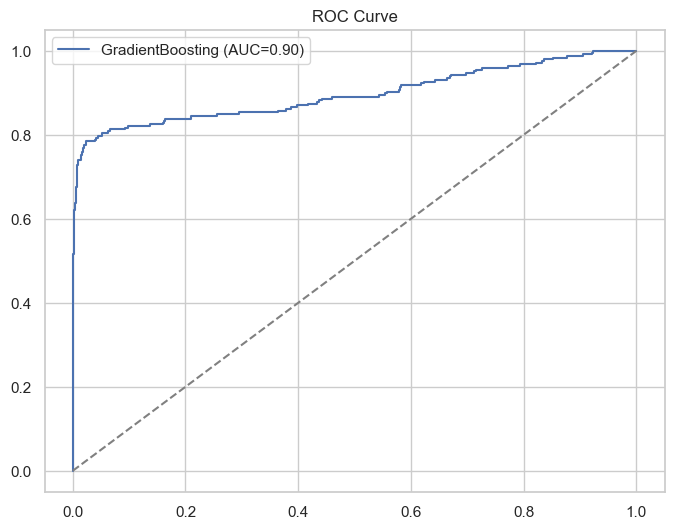

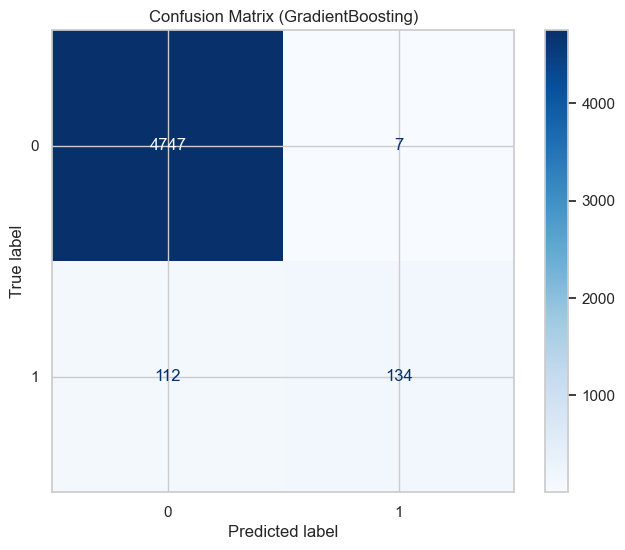

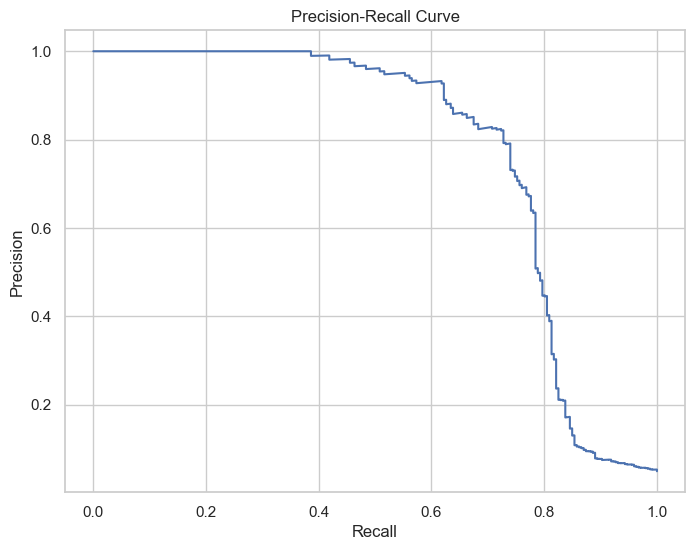

In [9]:
# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={metrics_test[best_model_name]['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.legend()
plt.savefig(FIGURES_DIR / "roc_curve.png")
plt.show()

# 2. Confusion Matrix
cm = confusion_matrix(y_test, best_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix ({best_model_name})")
plt.savefig(FIGURES_DIR / "confusion_matrix.png")
plt.show()

# 3. PR Curve
precision, recall, _ = precision_recall_curve(y_test, best_proba)
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.savefig(FIGURES_DIR / "pr_curve.png")
plt.show()

Считаем важность признаков


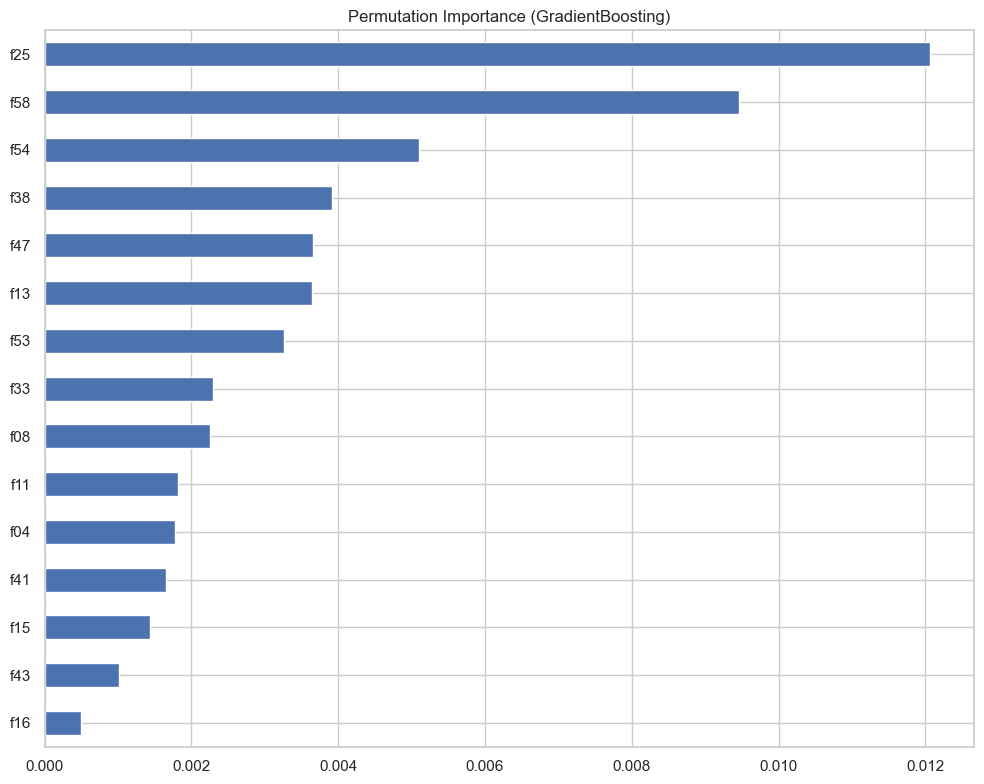

In [10]:
print("Считаем важность признаков")
perm = permutation_importance(
    best_model_obj,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=1 
)

# Permutation Importance
importances = pd.Series(
    perm.importances_mean,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Permutation Importance ({best_model_name})")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "permutation_importance.png")
plt.show()

In [11]:
# 1. Метрики
with open(ARTIFACTS_DIR / "metrics_test.json", "w") as f:
    json.dump(metrics_test, f, indent=4)

# 2. Параметры поиска
search_summaries = {
    "DecisionTree": dt_search.best_params_,
    "RandomForest": rf_search.best_params_,
    "GradientBoosting": gb_search.best_params_
}
with open(ARTIFACTS_DIR / "search_summaries.json", "w") as f:
    json.dump(search_summaries, f, indent=4)

# 3. Модель
joblib.dump(best_model_obj, ARTIFACTS_DIR / "best_model.joblib")

# 4. Метаданные
best_model_meta = {
    "best_model": best_model_name,
    "metrics_test": metrics_test[best_model_name]
}
with open(ARTIFACTS_DIR / "best_model_meta.json", "w") as f:
    json.dump(best_model_meta, f, indent=4)

print("Все файлы сохранены в artifacts/")

Все файлы сохранены в artifacts/
